In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trimesh
import open3d as o3d
import matplotlib.pyplot as plt
import os 

from data_load import correct_meshroom_extrinsics, get_image_data_from_json, get_camera_intrinsics_from_json
from mesh_utils import slice_mesh_with_fuse, create_masks_from_meshes, draw_mask_on_img
from visualisation import visualize_results, visualize_results_interactive

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
IMG_FOLDER_PATH = 'image_selection_data/P_1'
FILE_FORMAT = '.JPG'
POSES_FOLDER = 'poses'
image_name = 'DJI_20240418185815_0195_Z'

image_path = os.path.join(IMG_FOLDER_PATH, image_name + FILE_FORMAT) 



In [17]:
camera_info = {
        "id": "d0c8b88a-d4f1-4637-ac4f-85da04e7bb40",
        "offset_x": 8.309657515284046,
        "offset_y": 1.8107673354504856,
        "focal_length": 4800.232015738299,
        "k1": -0.008434033956924982,
        "k2": 0.07688060637564556,
        "k3": -0.07907662055042962,
        "p1": 0.0009069205914153655,
        "p2": 1.402695059969209e-05,
        "width": 5184,
        "height": 3888,
        "matrix": [
            [
                4800.232015738299,
                0.0,
                2600.309657515284
            ],
            [
                0.0,
                4800.232015738299,
                1945.8107673354505
            ],
            [
                0.0,
                0.0,
                1.0
            ]
        ],
        "distortion_coefficients": [
            -0.008434033956924982,
            0.07688060637564556,
            0.0009069205914153655,
            1.402695059969209e-05,
            -0.07907662055042962
        ]
    }

pose_info = {
    "center_x": -21.72083936294075,
    "center_y": -34.34368678275496,
    "center_z": 2.7943027446324322,
    "rotation_00": 0.9694059114998105,
    "rotation_01": -0.2451408350424042,
    "rotation_02": 0.0125757601732269,
    "rotation_10": 0.0499116335980566,
    "rotation_11": 0.1466943041991313,
    "rotation_12": -0.9879218642924684,
    "rotation_20": 0.2403351983809179,
    "rotation_21": 0.9583249720790156,
    "rotation_22": 0.1544417052125467,
    "image_original_name": "DJI_20240418185815_0195_Z",
    "center": [
        -21.72083936294075,
        -34.34368678275496,
        2.7943027446324322
    ],
    "rotation": [
        [
            0.9694059114998105,
            -0.2451408350424042,
            0.0125757601732269
        ],
        [
            0.0499116335980566,
            0.1466943041991313,
            -0.9879218642924684
        ],
        [
            0.2403351983809179,
            0.9583249720790156,
            0.1544417052125467
        ]
    ],
    "camera_id": "d0c8b88a-d4f1-4637-ac4f-85da04e7bb40"
}

In [18]:
MESH_PATH = 'image_selection_data/decimated_centered_textured_mesh.obj'

camera_matrix = np.float32(camera_info["matrix"])
distortion_coefficients = np.float32(camera_info["distortion_coefficients"])
rotation = np.float32(pose_info["rotation"]).reshape(3, 3)
center = np.float32(pose_info["center"]).reshape(3, 1)

pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, camera_info["height"], camera_info["width"], pier)

is_mesh_seen_by_camera = len(pier_cutted.vertices) != 0

In [19]:
camera_matrix = np.float32(camera_matrix)
distortion_coefficients = np.float32(distortion_coefficients)
rotation = np.float32(rotation).reshape(3, 3)
center = np.float32(center).reshape(3, 1)

pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, 5460, 8192, pier)

is_mesh_seen_by_camera = len(pier_cutted.vertices) != 0

In [20]:
def world_to_camera(vertices, camera_rotation, camera_position):
    vertices = np.array(vertices)
    camera_position = np.array(camera_position)
    camera_rotation = np.array(camera_rotation)
    
    camera_position = camera_position.reshape(1, 3)
    translated_vertices = vertices - camera_position
    rotated_vertices = np.dot(translated_vertices, camera_rotation.T)
        
    return rotated_vertices

In [27]:
vertices_camera = world_to_camera(pier_cutted.vertices, rotation, center)
translation_cam = (-rotation @ center).reshape(3, 1)
projected_vertices, _ = cv.projectPoints(np.float64(vertices_camera), np.float64(rotation), np.float64(translation_cam), np.float64(camera_matrix), np.float64(distortion_coefficients))
projected_vertices = projected_vertices.squeeze().astype(np.int64)

In [48]:
image_size = (5460, 8192)

print(f"Total vertices: {len((pier_cutted.vertices))}")
print(f"Vertices in camera coordinates shape: {vertices_camera.shape}")
print(f"Vertices in image coordinates shape: {projected_vertices.shape}")
in_front_of_camera = vertices_camera[:, 2] > 0
within_x_bounds = (projected_vertices[:, 0] >= 0) & (projected_vertices[:, 0] < image_size[1])
within_y_bounds = (projected_vertices[:, 1] >= 0) & (projected_vertices[:, 1] < image_size[0])
within_image_bounds = within_x_bounds & within_y_bounds
potentially_visible = in_front_of_camera & within_image_bounds
print(f"Vertices in front of camera: {np.sum(in_front_of_camera)}")
print(f"Vertices within image boundaries: {np.sum(within_image_bounds)}")
print(f"Potentially visible vertices: {np.sum(potentially_visible)}")
potential_indices = np.where(potentially_visible)[0]      


Total vertices: 2252
Vertices in camera coordinates shape: (2252, 3)
Vertices in image coordinates shape: (2252, 2)
Vertices in front of camera: 2252
Vertices within image boundaries: 654
Potentially visible vertices: 654


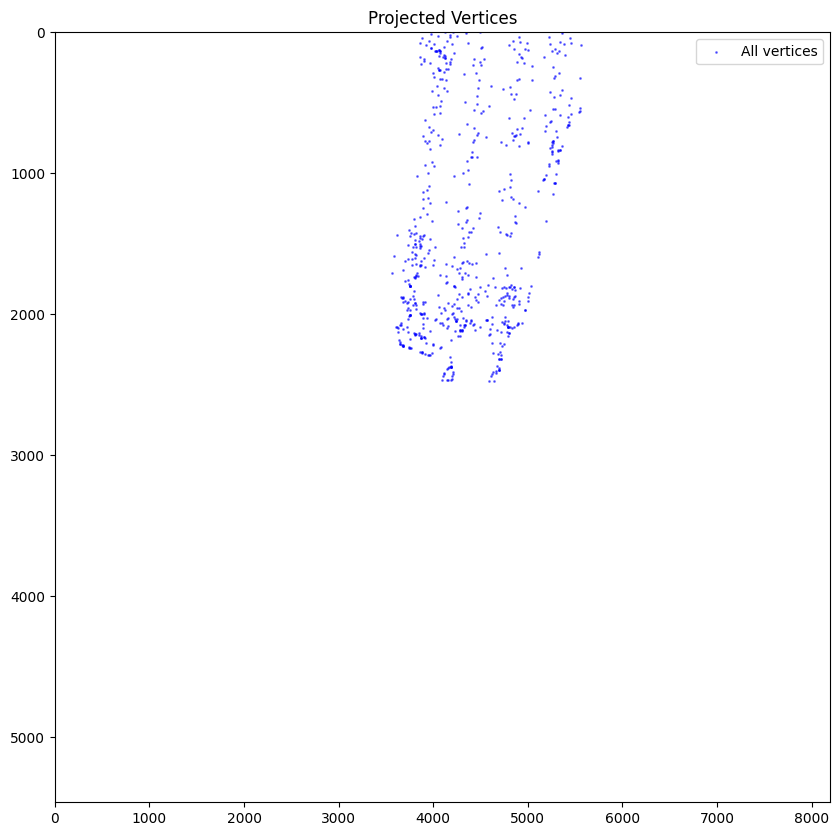

In [28]:
def visualize_projected(vertices_image, image_size):
    plt.figure(figsize=(10, 10))
    plt.scatter(vertices_image[:, 0], vertices_image[:, 1], c='blue', s=1, alpha=0.5, label='All vertices')
    plt.xlim(0, image_size[1])
    plt.ylim(image_size[0], 0)
    plt.legend()
    plt.title('Projected Vertices')
    plt.show()

# Call this function after get_visible_vertices
visualize_projected(projected_vertices, (5460, 8192))

In [75]:
rays_directions = pier_cutted.vertices - center.squeeze()
distances = np.linalg.norm(rays_directions, axis=1)
rays_directions /= distances.reshape(-1, 1)
print(distances.shape)
print(len(rays_directions))
rays_origins = np.tile(center.squeeze(), (len(rays_directions), 1))

print(rays_directions.shape)
print(rays_origins.shape)

locations, index_ray, index_tri = pier_cutted.ray.intersects_location(
    ray_origins=rays_origins,
    ray_directions=rays_directions
)

if locations.size == 0:
    print("error")
    
# Calculate distances from the center of all the projected points
distances = np.linalg.norm(locations - center.transpose(), axis=1).reshape(-1, 1)

defect_3d_vertices = np.zeros((len(projected_vertices), 3), dtype=np.float32)
correctly_projected_points = 0

visible = []
print('potential_indices', len(potential_indices))
for i in potential_indices:
    projected_points_for_i = locations[index_ray == i]

    if projected_points_for_i.size == 0:
        continue

    # distances_ray_i = distances[index_ray == i]
    # closest_index = np.argmin(distances_ray_i)
    # print(projected_points_for_i[closest_index])
    if projected_points_for_i.shape[0] == 1:
        visible.append(i)
    correctly_projected_points += 1
print('correctly_projected_points', correctly_projected_points)

(2252,)
2252
(2252, 3)
(2252, 3)
potential_indices 654
correctly_projected_points 607


In [78]:
from visualisation import visualize_results, visualize_results_interactive

In [79]:
camera_position = -np.matmul(rotation, center).flatten()
# camera_position_fix = np.array([camera_position[1], camera_position[2], camera_position[0]])
visualize_results_interactive(pier_cutted, visible, camera_position, rotation, center)